# Spiral ODE

*You are seeing the
notebook output generated by
[Literate.jl](https://github.com/fredrikekre/Literate.jl) from the
[Julia source file](https://github.com/Crown421/GPDiffEq.jl/blob/main/examples/spiral/script.jl).
The rendered HTML can be viewed [in the docs](https://juliagaussianprocesses.github.io/AbstractGPs.jl/dev/examples/spiral/).*

## Setup

Load necessary packages

In [1]:
using ApproximateGPs
using Plots
using LinearAlgebra
using DifferentialEquations
using InducingPoints
using GPDiffEq
using Optimization, OptimizationOptimJL

First we define an ODE and generate some data points from it.

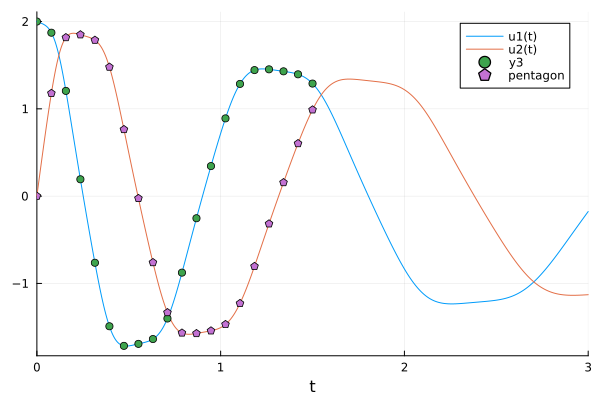

In [2]:
u0 = [2.0; 0.0]
datasize = 20
tspan = (0.0, 3.0)
datatspan = (0.0, 1.5)
datatsteps = range(datatspan[1], datatspan[2]; length=datasize)

function trueODEfunc(u, p, t)
    du = similar(u)
    true_A = [-0.1 2.0; -2.0 -0.1]
    return du .= ((u .^ 3)'true_A)'
end

prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
sol = solve(prob_trueode, Tsit5())
ode_data = Array(sol(datatsteps))

traj = sol(datatsteps);

p = plot(sol)
scatter!(p, datatsteps, ode_data[1, :]; markersize=4)#, markerstyle = :star)
scatter!(p, datatsteps, ode_data[2, :]; m=(4, :pentagon), lab="pentagon")#, markerstyle = :star)

## Gradient data
For this example we get gradient observations from our trajectory data via finite differences

First, we set all necessary variables

In [3]:
scaker = with_lengthscale(SqExponentialKernel(), 1.0)
moker = IndependentMOKernel(scaker)
##ToDo: make ODE data into col_vecs and add number programmatically
x = MOInput(datatsteps, 2)
σ_n = 1e-6
y = ode_data'[:]
nothing #hide

and build a finite GP from them

In [4]:
g = GP(moker)
gt = g(x, σ_n)
gt_post = posterior(gt, y)
nothing #hide

Now we use the following convenience functions to a loglikelihood loss function and a function to rebuild the gp with the optimal parameters.
Note that we use optimize over the logarithm of the parameters, to ensure their positivity. For more details see [this KernelFunctions.jl example](https://juliagaussianprocesses.github.io/KernelFunctions.jl/dev/examples/train-kernel-parameters/)

In [5]:
loss, buildgppost = gp_negloglikelihood(gt, x, y)

p0 = log.([1.0])
unfl(x) = exp.(x)

#optp = gp_train(loss ∘ unfl, p0; show_trace=true, show_every=15)

unfl (generic function with 1 method)

Optimizing:

In [6]:
adtype = Optimization.AutoZygote()

optf = Optimization.OptimizationFunction((x, p) -> (loss ∘ unfl)(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p0)

optp = Optimization.solve(optprob, NelderMead(); maxiters=300)

optparams = unfl(optp)

1-element Vector{Float64}:
 7.268328510367432

Now we can build a FiniteGP with the optimized parameters,

In [7]:
optpost = buildgppost(optparams)
nothing #hide

which fits pretty well

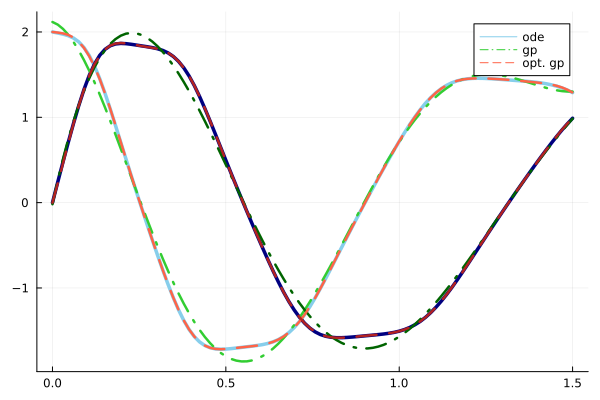

In [8]:
t_plot = range(datatspan...; length=100)
t_plot_mo = MOInput(t_plot, 2)
opt_pred_mean = mean(optpost, t_plot_mo)
opt_pred_mean = reshape(opt_pred_mean, :, 2)
pred_mean = mean(gt_post, t_plot_mo)
pred_mean = reshape(pred_mean, :, 2)
# pred_cov = diag(cov(optpost, t_plot_mo))
# pred_cov = reshape(pred_cov, :, 2)
# plot!(t_plot, pred_mean; ribbons = pred_cov)
plot(sol(t_plot); label=["ode" ""], color=[:skyblue :navy], linewidth=3.5)
plot!(
    t_plot,
    pred_mean;
    label=["gp" ""],
    color=[:limegreen :darkgreen],
    linewidth=2.5,
    linestyle=:dashdot,
)
plot!(
    t_plot,
    opt_pred_mean;
    label=["opt. gp" ""],
    color=[:tomato :firebrick],
    linewidth=2.5,
    linestyle=:dash,
)

GPs are closed under linear operators, which means that we can very easily obtain derivative information:

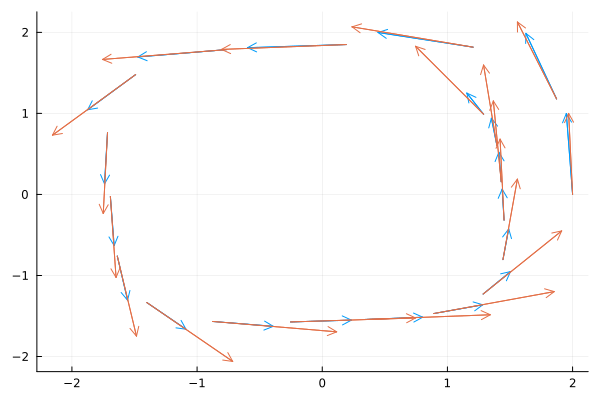

In [9]:
deriv_post = differentiate(optpost)
du_pred_mean = mean(deriv_post, x)
du_pred_mean = reshape(du_pred_mean, :, 2)
du_pred_mean = du_pred_mean ./ norm.(eachrow(du_pred_mean))

du = trueODEfunc.(eachcol(ode_data), 0, 0)
du = du ./ maximum(norm.(du))
quiver(ode_data[1, :], ode_data[2, :]; quiver=(getindex.(du, 1), getindex.(du, 2)))
quiver!(ode_data[1, :], ode_data[2, :]; quiver=(du_pred_mean[:, 1], du_pred_mean[:, 2]))

This leaves us with `u` and `udot` pairs as in the input and output:

In [10]:
u = ColVecs(ode_data)
udot = ColVecs(du_pred_mean')

20-element KernelFunctions.ColVecs{Float64, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, SubArray{Float64, 1, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, false}}:
 [-0.03165347046698772, 0.9994989033547739]
 [-0.3131227464619143, 0.9497126647824319]
 [-0.9679245733258961, 0.251240960736664]
 [-0.9981774178119854, -0.06034768073585721]
 [-0.9925599672581026, -0.12175677146095097]
 [-0.6642477894990115, -0.7475124575187205]
 [-0.03420468135829994, -0.9994148486855582]
 [0.045374704086262395, -0.9989700377033758]
 [0.1533555686837154, -0.9881710730200991]
 [0.6865910743527178, -0.7270438065338158]
 [0.9917640001668678, -0.1280787569154741]
 [0.9987723387326086, 0.04953600087406405]
 [0.9983241843164803, 0.057869015965663614]
 [0.9626976689863879, 0.2705793749127511]
 [0.6273635437792426, 0.7787265142119859]
 [0.1154155588390388, 0.9933172951166572]
 [-0.03179474807481451, 0.9994944191914525]
 [-0.06279683463643287, 0.9980263310953498]


## Building a model
Now we build a model for the the ODE.

In [11]:
scaker = with_lengthscale(SqExponentialKernel(), ones(2))
moker = IndependentMOKernel(scaker)

u_mo = MOInput(u, 2)
σ_n = 1e-6
y = reduce(vcat, udot.X)
nothing #hide

and build a posterior GP

In [12]:
gpmodel = GP(moker)
fin_gpmodel = gpmodel(u_mo, σ_n)
post_gpmodel = posterior(fin_gpmodel, y)

AbstractGPs.PosteriorGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}, NamedTuple{(:α, :C, :x, :δ), Tuple{Vector{Float64}, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}, KernelFunctions.MOInputIsotopicByOutputs{SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}, KernelFunctions.ColVecs{Float64, Matrix{Float64}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Base.Slice{Base.OneTo{Int64}}, Int64}, true}}, Int64}, Vector{Float64}}}}(AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.IndependentMOKernel{KernelFunctions.TransformedKernel{KernelFunctions.SqExponentialKernel{Distances.Euclidean}, KernelFunctions.ARDTransform{Vector{Float64}}}}}(AbstractGPs.ZeroMean{Float64}(), Independent Multi-Output Kernel
	Squared Exponential Kernel (metric = Distances.Euclidean(0.0))

and optimize

In [13]:
loss, buildgppost = gp_negloglikelihood(fin_gpmodel, u_mo, y)

p0 = log.(ones(2))
unfl(x) = exp.(x)

optf = Optimization.OptimizationFunction((x, p) -> (loss ∘ unfl)(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p0)

optp = Optimization.solve(optprob, NelderMead(); maxiters=300)

optparams = unfl(optp)

2-element Vector{Float64}:
  0.6525913342039246
 42.572978622897175

We build a posterior GP with the optimized parameters,

In [14]:
optpost = buildgppost(optparams)
nothing #hide

and incorporate into a GP ode model. Unfortunately, this does not currently match the previous implementation.

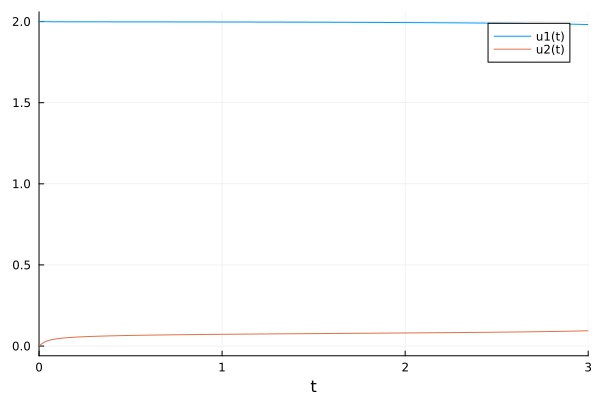

In [15]:
gpode = GPODE(optpost, tspan)
gpsol = gpode(u0)

plot(gpsol)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*